In [ ]:
!git clone https://github.com/JiaRenChang/PSMNet.git
%cd PSMNet

Cloning into 'PSMNet'...
remote: Enumerating objects: 335, done.
remote: Total 335 (delta 0), reused 0 (delta 0), pack-reused 335 (from 1)
Receiving objects: 100% (335/335), 103.18 KiB | 1.29 MiB/s, done.
Resolving deltas: 100% (200/200), done.
/content/PSMNet


In [ ]:
import torch
model_path = "/content/pretrained_model_KITTI2015.tar"

# Load the state dictionary directly from the tar file
state_dict = torch.load(model_path, map_location=torch.device("cuda" if torch.cuda.is_available() else "cpu"))

<ipython-input-3-ee1bc4759221>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_location=torch.device("cuda" if torch.cuda.is_availab

<ipython-input-5-357422fd56e9>:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_weights = torch.load(model_path, map_location=device)
/content/PSMNet/models/subm

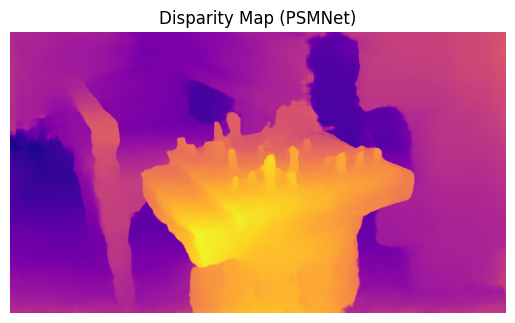

In [ ]:
import os
import torch
import torchvision.transforms as transforms
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PSMNet.models import stackhourglass  # Import PSMNet model

# Load PSMNet Model
def load_psmnet_model(model_path):
    """
    Load the pretrained PSMNet model.

    Parameters:
        model_path (str): Path to the pretrained model.

    Returns:
        model: Loaded PSMNet model.
    """
    import torch
    from collections import OrderedDict
    from PSMNet.models import stackhourglass

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Initialize the model
    model = stackhourglass(192)  # Maximum disparity is 192
    model = model.to(device)

    # Load the pretrained weights
    pretrained_weights = torch.load(model_path, map_location=device)

    # Fix "module." prefix if it exists
    state_dict = pretrained_weights["state_dict"]
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        new_key = k.replace("module.", "")  # Remove "module." prefix
        new_state_dict[new_key] = v

    # Load the updated state dictionary
    model.load_state_dict(new_state_dict)
    model.eval()

    return model, device


# Preprocess Stereo Images
def preprocess_images(left_image_path, right_image_path):
    """
    Preprocess the left and right stereo images.

    Parameters:
        left_image_path (str): Path to the left stereo image.
        right_image_path (str): Path to the right stereo image.

    Returns:
        left_tensor, right_tensor: Preprocessed tensors for the model.
    """
    # Read and resize images
    left_img = cv2.imread(left_image_path)
    right_img = cv2.imread(right_image_path)
    left_img = cv2.cvtColor(left_img, cv2.COLOR_BGR2RGB)
    right_img = cv2.cvtColor(right_img, cv2.COLOR_BGR2RGB)

    # Resize to a fixed size (960x544)
    left_img = cv2.resize(left_img, (960, 544))
    right_img = cv2.resize(right_img, (960, 544))

    # Normalize images
    preprocess = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    left_tensor = preprocess(left_img).unsqueeze(0)
    right_tensor = preprocess(right_img).unsqueeze(0)

    return left_tensor, right_tensor


# Predict Disparity
def predict_disparity(model, device, left_tensor, right_tensor):
    """
    Perform inference using PSMNet.

    Parameters:
        model: Loaded PSMNet model.
        device: Device (CPU or GPU).
        left_tensor, right_tensor: Preprocessed stereo tensors.

    Returns:
        disparity_map (numpy.ndarray): Predicted disparity map.
    """
    left_tensor = left_tensor.to(device)
    right_tensor = right_tensor.to(device)

    # Run inference
    with torch.no_grad():
        output = model(left_tensor, right_tensor)
    disparity_map = output.squeeze(0).cpu().numpy()

    return disparity_map


# Visualize and Save Disparity Map
def visualize_and_save_disparity(disparity_map, output_path="disparity_map.png"):
    """
    Visualize and save the disparity map.

    Parameters:
        disparity_map (numpy.ndarray): Predicted disparity map.
        output_path (str): Path to save the disparity map.
    """
    # Normalize disparity map for visualization
    disparity_normalized = (disparity_map - disparity_map.min()) / (disparity_map.max() - disparity_map.min())
    disparity_normalized = (disparity_normalized * 255).astype(np.uint8)

    # Display the disparity map

    plt.imshow(disparity_normalized.reshape(544, 960), cmap="plasma")
    plt.title("Disparity Map (PSMNet)")
    plt.axis("off")
    plt.show()

    # Save the disparity map
    cv2.imwrite(output_path, disparity_normalized)


# Paths to the input stereo images
left_image_path = "/content/chess1.jpg"   # Replace with uploaded left image filename
right_image_path = "/content/chess2.jpg" # Replace with uploaded right image filename
model_path = "/content/pretrained_model_KITTI2015.tar"

# Load the PSMNet model
model, device = load_psmnet_model(model_path)

# Preprocess stereo images
left_tensor, right_tensor = preprocess_images(left_image_path, right_image_path)

# Predict disparity
disparity_map = predict_disparity(model, device, left_tensor, right_tensor)

# Visualize and save the disparity map
visualize_and_save_disparity(disparity_map, output_path="psmnet_disparity_map.png")



In [ ]:
from google.colab.patches import cv2_imshow  # For displaying images in Colab

def analyze_depth_map(depth_map):
    """
    Analyze the depth map by detecting contours, approximating polygons,
    and identifying convexities/concavities.

    Parameters:
        depth_map (numpy.ndarray): Input depth map.

    Returns:
        contours (list): Contours detected in the depth map.
        approx_polygons (list): Approximated polygons for each contour.
        contour_types (list): Types of contours ('hole' or 'object').
    """
    # Normalize the depth map to [0, 1]
    depth_map_normalized = (depth_map - depth_map.min()) / (depth_map.max() - depth_map.min())

    # Convert depth map to binary using thresholding
    threshold_value = 0.5  # Adjust this threshold based on your application
    _, depth_map_binary = cv2.threshold(depth_map_normalized, threshold_value, 1, cv2.THRESH_BINARY)
    depth_map_binary = depth_map_binary.astype(np.uint8)

    # Find contours
    contours, hierarchy = cv2.findContours(depth_map_binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    approx_polygons = []  # Store approximated polygons
    contour_types = []    # Store types of contours ('hole' or 'object')

    for contour in contours:
        # Approximate polygon for the contour
        epsilon = 0.01 * cv2.arcLength(contour, True)  # Adjust epsilon multiplier as needed
        approx = cv2.approxPolyDP(contour, epsilon, True)
        approx_polygons.append(approx)

        # Determine contour type based on area
        area = cv2.contourArea(contour)
        contour_types.append('hole' if area < 0 else 'object')

    return contours, approx_polygons, contour_types

# Example usage
depth_map = disparity_map
contours, approx_polygons, contour_types = analyze_depth_map(depth_map)

print(f"Detected {len(contours)} contours.")


def display_approximated_polygons(depth_map):
    """
    Display approximated polygons on a depth map or binary image.

    Parameters:
        depth_map (numpy.ndarray): Input depth map.
    """
    # Normalize the depth map to [0, 1]
    depth_map_normalized = (depth_map - depth_map.min()) / (depth_map.max() - depth_map.min())

    # Convert depth map to binary using thresholding
    threshold_value = 0.5  # Adjust threshold based on your application
    _, depth_map_binary = cv2.threshold(depth_map_normalized, threshold_value, 1, cv2.THRESH_BINARY)
    depth_map_binary = (depth_map_binary * 255).astype(np.uint8)  # Convert to 8-bit format

    # Find contours
    contours, _ = cv2.findContours(depth_map_binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Create an image to visualize the polygons
    visualization_image = np.zeros_like(depth_map_binary)
    visualization_image = cv2.cvtColor(visualization_image, cv2.COLOR_GRAY2BGR)

    for contour in contours:
        # Approximate the polygon for each contour
        epsilon = 0.01 * cv2.arcLength(contour, True)  # Adjust epsilon as needed
        approx = cv2.approxPolyDP(contour, epsilon, True)

        # Draw the approximated polygon on the visualization image
        cv2.drawContours(visualization_image, [approx], -1, (0, 255, 0), 2)  # Green color for polygons

    # Display the image with approximated polygons
    cv2_imshow(visualization_image)

# Example usage
display_approximated_polygons(depth_map)


Detected 0 contours.


In [ ]:
assert np.max(self.initializer_image) <= 1 and np.min(self.initializer_image) >= 0, f"Expected image pixel values range to be between 0 and 1 - {self.initializer_image}"
		_, self.initializer_image_binary = cv2.threshold(self.initializer_image, 0.5, 1, cv2.THRESH_BINARY)
		self.initializer_image_binary = self.initializer_image_binary.astype(np.uint8)

		## 2 - Deduce convexities and concavities
		contours, hierarchy = cv2.findContours(self.initializer_image_binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
		approx_polygons = [] # Loop over the contours and approximate the polygons
		corner_infos = []  # To store information about corners
		contour_types = [] # Hole or object, per contour
		for contour in contours:
			epsilon = EPSILON_MULTIPLIER * cv2.arcLength(contour, True)
			approx = cv2.approxPolyDP(contour, epsilon, True)  # Approximate the polygon
			approx_polygons.append(approx)
			corner_infos.append([])

			area = cv2.contourArea(contour)
			contour_types.append('hole' if area < 0 else 'object')

			for i in range(len(approx)): # Analyze each corner
				p2 = approx[i][0]      # Current point (corner)
				corner_infos[-1].append({"pos": tuple(p2)}) # Append the results (corner position, type, slope change)